<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png" height="50px"> <a href='https://harvard-iacs.github.io/2021-AC215/' target='_blank'><strong><font color="#A41034">AC215: Advanced Practical Data Science, MLOps</font></strong></a></h1>

# **<font color="#A41034">Exercise 3 - Mushroom Identification Models</font>**

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructor:**<br/>
Pavlos Protopapas

<hr style="height:2pt">

## **<font color="#A41034">Competition</font>**

### **<font color="#f03b20">Due Date: Check Canvas</font>**

#### **[View Leaderboard](http://ac215-leaderboard.dlops.io/)**

Now your task for this exercise is to build the best model for mushroom classification. You are free to use any techniques. Here are some techniques you can try:

* Data augmentation
* Hyper parameters tuning
* Transfer Learning using different pre-trained models
* Learning rate schedulers
* Early stopping
* etc...

#### **Exercise Requirements:**
* Create TF Records to build your data pipelines
* Perform model compression using Distillation
* Perform model compression using Pruning

You can submit as many models as you want with any techniques used but make sure to keep your work based on the above requirements before you submit your notebook on canvas

<br>

**Remember to submit your experiments to the cloud storage bucket using the code provided and also submit your notebook to Canvas**

<br>

**<font color="#f03b20">Leaderboard for this competition will be computed based on `hidden` test set. Winner gets a $50 Amazon gift card from Pavlos</font>**

## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Imports**

In [ ]:
!pip install -q tensorflow_model_optimization

     |████████████████████████████████| 213 kB 4.3 MB/s 


In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

# Tensorflow Hub
import tensorflow_hub as hub

# Colab auth
from google.colab import auth
from google.cloud import storage

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [ ]:
!nvidia-smi

Mon Oct  4 19:36:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    62W / 149W |    123MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this notebook

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def upload_experiment(data_details):
  
  # Check the logged in account
  user_account = !gcloud config get-value account
  user_account = user_account[0]
  print("user_account",user_account)

  # Check Bucket Access
  bucket_name = "ac215-mushroom-app-models" # BUCKET NAME

  # List buckets in a GCP project
  storage_client = storage.Client(project="ac215-project") # PROJECT ID 

  # Get bucket for Experiments
  bucket = storage_client.get_bucket(bucket_name)
  print("Model Bucket:",bucket)

  # Save data details used for the experiment
  save_data_details(data_details)

  # Copy the experiment folder to GCP Bucket
  for file_path in glob(experiment_name+'/*'):
    print(file_path)
    blob = bucket.blob(os.path.join(user_account,file_path)) 
    print('uploading file', file_path)
    blob.upload_from_filename(file_path)
  
  # Submit file
  submit_file = "submit.txt"
  with open(submit_file, "w") as f:
    f.write("Submission!")

  blob = bucket.blob(submit_file) 
  print('Uploading file', submit_file)
  blob = bucket.blob(os.path.join(user_account,experiment_name,submit_file)) 
  blob.upload_from_filename(submit_file)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history):
  for metric in ["loss","val_loss","accuracy","val_accuracy"]:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)
  
  return model_train_history

def evaluate_save_model(model,test_data, model_train_history,execution_time, learning_rate, batch_size, epochs, optimizer,
                        save=True, loss_metrics=['loss', 'val_loss'], acc_metrics=['accuracy', 'val_accuracy'], evaluation_results=None):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  if not evaluation_results:
    evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## **<font color="#A41034">Dataset</font>**

#### **Download**

In [ ]:
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/mushrooms_6_labels.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.7709474523862203


#### **Load & EDA**

In [ ]:
# Your Code Here
base_path = os.path.join("datasets","mushrooms")
label_names = os.listdir(base_path)
print("Labels:", label_names)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path,label))
  data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

print("Full size of the dataset:",len(data_list))
print("data_list:",data_list[:5])

Labels: ['maitake', 'amanita', 'portabello', 'shiitake', 'oyster', 'crimini']
Full size of the dataset: 3365
data_list: [('maitake', 'datasets/mushrooms/maitake/73.jpg'), ('maitake', 'datasets/mushrooms/maitake/86.jpg'), ('maitake', 'datasets/mushrooms/maitake/258.jpg'), ('maitake', 'datasets/mushrooms/maitake/430.jpg'), ('maitake', 'datasets/mushrooms/maitake/220.jpg')]


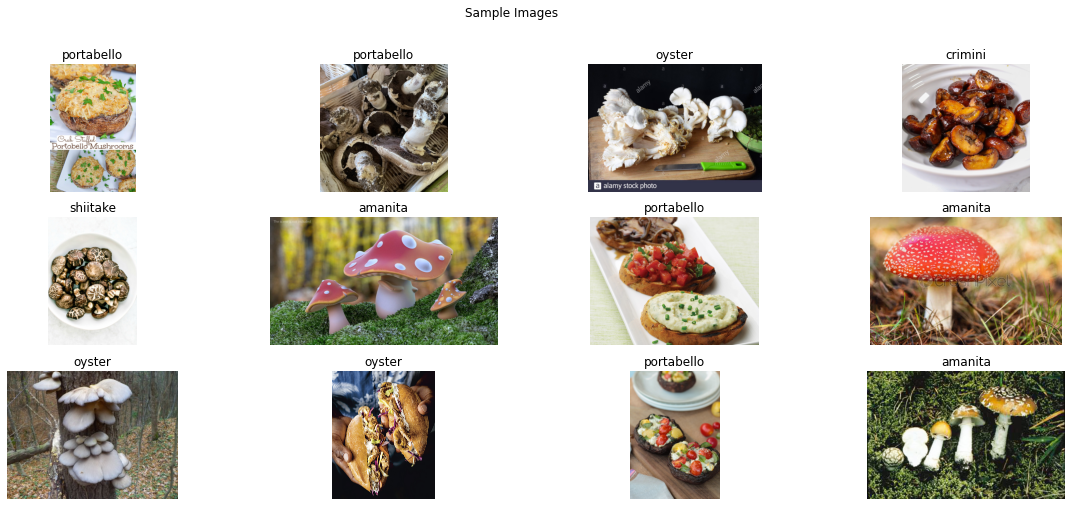

In [ ]:
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

In [ ]:
compute_dataset_metrics(data_list)

Dataset Metrics:
----------------
Label Counts:
oyster        684
portabello    600
shiitake      559
crimini       534
amanita       522
maitake       466
Name: label, dtype: int64
Image Width:
Min: 134.0  Max: 4368.0
Image Height:
Min: 90.0  Max: 4494.0
Size in memory: 9572.36 MB


## **<font color="#A41034">Build Data Pipelines</font>**

In [ ]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 128

In [ ]:
test_percent = 0.1
validation_percent = 0.2

# Split data into train / test
train_validate_xy, test_xy = train_test_split(data_list, test_size=test_percent)

# Split data into train / validate
train_xy, validate_xy = train_test_split(train_validate_xy, test_size=validation_percent)

print("train_x count:",len(train_xy))
print("validate_x count:",len(validate_xy))
print("test_x count:",len(test_xy))

train_x count: 2422
validate_x count: 606
test_x count: 337


In [ ]:
def create_tf_example(item):

  # Read image
  image = tf.io.read_file(item[1])
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  # # Encode
  # image = tf.cast(image, tf.uint8)
  # image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  image = tf.cast(image, tf.uint8)

  # Label
  label = label2index[item[0]]

  # Build feature dict
  feature_dict = {
      'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy().tobytes()])),
      'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
  }

  example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
  return example

def create_tf_records(data,num_shards=10, prefix='', folder='data'):
  num_records = len(data)
  step_size = num_records//num_shards + 1

  for i in range(0, num_records, step_size):
    print("Creating shard:",(i//step_size)," from records:",i,"to",(i+step_size))
    path = '{}/{}_000{}.tfrecords'.format(folder, prefix, i//step_size)
    print(path)

    # Write the file
    with tf.io.TFRecordWriter(path) as writer:
      # Filter the subset of data to write to tfrecord file
      for item in data[i:i+step_size]:
        tf_example = create_tf_example(item)
        writer.write(tf_example.SerializeToString()) 

In [ ]:
# Create an output path to store the tfrecords
tfrecords_output_dir = "mushroom_tfrecords"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 12

# Create TF Records for train
start_time = time.time()
create_tf_records(train_xy,num_shards=num_shards, prefix="train", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 4

# Create TF Records for validation
start_time = time.time()
create_tf_records(validate_xy,num_shards=num_shards, prefix="val", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 2

# Create TF Records for test
start_time = time.time()
create_tf_records(test_xy,num_shards=num_shards, prefix="test", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Creating shard: 0  from records: 0 to 202
mushroom_tfrecords/train_0000.tfrecords
Creating shard: 1  from records: 202 to 404
mushroom_tfrecords/train_0001.tfrecords
Creating shard: 2  from records: 404 to 606
mushroom_tfrecords/train_0002.tfrecords
Creating shard: 3  from records: 606 to 808
mushroom_tfrecords/train_0003.tfrecords
Creating shard: 4  from records: 808 to 1010
mushroom_tfrecords/train_0004.tfrecords
Creating shard: 5  from records: 1010 to 1212
mushroom_tfrecords/train_0005.tfrecords
Creating shard: 6  from records: 1212 to 1414
mushroom_tfrecords/train_0006.tfrecords
Creating shard: 7  from records: 1414 to 1616
mushroom_tfrecords/train_0007.tfrecords
Creating shard: 8  from records: 1616 to 1818
mushroom_tfrecords/train_0008.tfrecords
Creating shard: 9  from records: 1818 to 2020
mushroom_tfrecords/train_0009.tfrecords
Creating shard: 10  from records: 2020 to 2222
mushroom_tfrecords/train_00010.tfrecords
Creating shard: 11  from records: 2222 to 2424
mushroom_tfrecor

In [ ]:
# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([num_channels * image_height * image_width])
  image = tf.reshape(image, [image_height, image_width, num_channels])
  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  #label = tf.one_hot(label, num_classes)

  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Read the tfrecord files
train_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/train*')
validate_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/val*')
test_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/test*')

#############
# Train data
#############
train_data = train_tfrecord_files.flat_map(tf.data.TFRecordDataset)
train_data = train_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validate_tfrecord_files.flat_map(tf.data.TFRecordDataset)
validation_data = validation_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)


##################
# Test data
##################
test_data = test_tfrecord_files.flat_map(tf.data.TFRecordDataset)
test_data = test_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(normalize, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
validation_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
test_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


## **<font color="#A41034">Build Image Classificaton Models</font>**

### **Create Experiment**

Use the util functions to create an experiment to keep track of hyper parameters, metrics, models etc. This will be used for your submission to the cloud storage

In [ ]:
# Create an experiment
create_experiment()

### **Build Distiller Model**

In [ ]:
# Your Code Here
def build_teacher_model(image_height, image_width, num_channels, num_classes, trainable):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model (Use a different model here)
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
                                hub.KerasLayer(handle, trainable=trainable),
        keras.layers.Dense(units=64, activation='relu',
                           kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                           bias_regularizer=keras.regularizers.l1(bias_weight)
                           ),
        keras.layers.Dense(units=num_classes,
                           kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                           bias_regularizer=keras.regularizers.l1(bias_weight)),
  ],name='teacher_model')

  return model


def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels

  model = Sequential(
      [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=1212)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same", 
                            kernel_initializer=keras.initializers.GlorotUniform(seed=2121)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Flatten(),
        keras.layers.Dense(units=32, kernel_initializer=keras.initializers.GlorotUniform(seed=2323)),
        keras.layers.Dense(units=num_classes, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
      ],
      name=model_name)

  return model


class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, Lambda = 0.1, temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      lambda: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn

      #hyper-parameters
      self.Lambda = Lambda
      self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher (professor)
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.Lambda * student_loss + (1 - self.Lambda) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

### **Train Distiller**

Model: "teacher_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 2,340,358
Trainable params: 2,306,246
Non-trainable params: 34,112
_________________________________________________________________
None
Epoch 1/20
19/19 - 35s - loss: 44.0286 - sparse_categorical_accuracy: 0.6738 - val_loss: 32.0155 - val_sparse_categorical_accuracy: 0.5710
Epoch 2/20
19/19 - 28s - loss: 21.8794 - sparse_categorical_accuracy: 0.8807 - val_loss: 14.2414 - val_sparse_categorical_accuracy: 0.6007
Epoch 3/20
19/19 - 27s - loss: 8.2981 - sparse_categorical_accuracy: 0.9451 - val_los

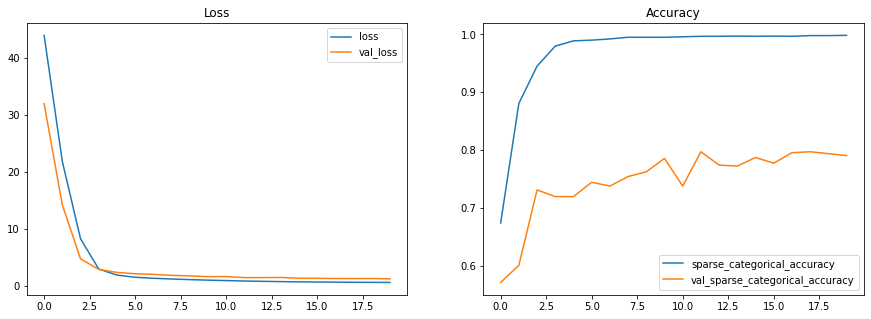

3/3 [==============================] - 1s 231ms/step - loss: 1.4480 - sparse_categorical_accuracy: 0.7537
[1.4479857683181763, 0.7537091970443726]


In [ ]:
# Train Teacher

learning_rate = 0.001
initial_epoch = 0
epochs = 20

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Build Model
teacher_model = build_teacher_model(image_height, image_width, num_channels, num_classes, trainable=True)
print(teacher_model.summary())

# Compile
teacher_model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.SparseCategoricalAccuracy()])


# Train model
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model', monitor='val_loss', 
                                                save_best_only=True, save_weights_only=True)
start_time = time.time()
training_results = teacher_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        verbose=2,
        callbacks=[earlystopping, checkpoint])
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
teacher_model.load_weights('best_model')
evaluate_save_model(teacher_model,test_data, training_history,execution_time, 
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"]
                    )

Model: "student_distill"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)          

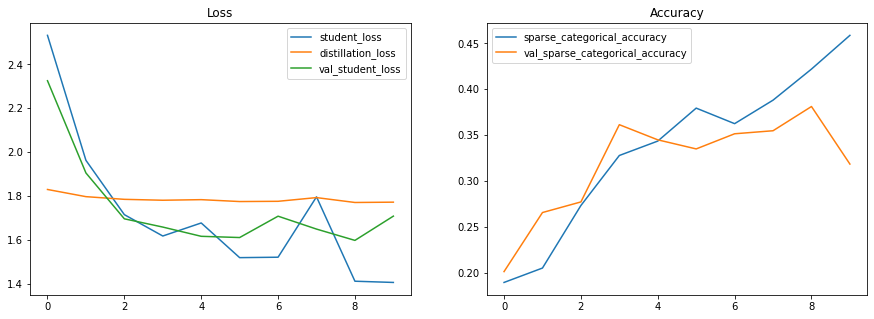

[1.6135783195495605, 0.3531157374382019]


In [ ]:
learning_rate = 0.01
epochs = 10
Lambda = 0.75
temperature= 5

# Free up memory
K.clear_session()

# Build Student model
student_model = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_distill')
print(student_model.summary())

# Build the distiller model
distiller_model = Distiller(teacher=teacher_model, student=student_model)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
student_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#distillation_loss = keras.losses.KLDivergence()
distillation_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    Lambda=Lambda,
    temperature=temperature
)

# Distill teacher to student
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_distiller', monitor='val_student_loss', 
                                                save_best_only=True, save_weights_only=True)
start_time = time.time()
training_results = distiller_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1,
        callbacks=[checkpoint])
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
distiller_model.load_weights('best_distiller')
evaluation_results = distiller_model.evaluate(test_data, return_dict=True)
evaluation_results = [evaluation_results['student_loss'], evaluation_results['sparse_categorical_accuracy']]
evaluate_save_model(student_model,test_data, 
                    training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    loss_metrics=["student_loss","distillation_loss","val_student_loss"],
                    acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"],
                    evaluation_results=evaluation_results)

### **Build Pruning Model**

Model: "pruning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0   

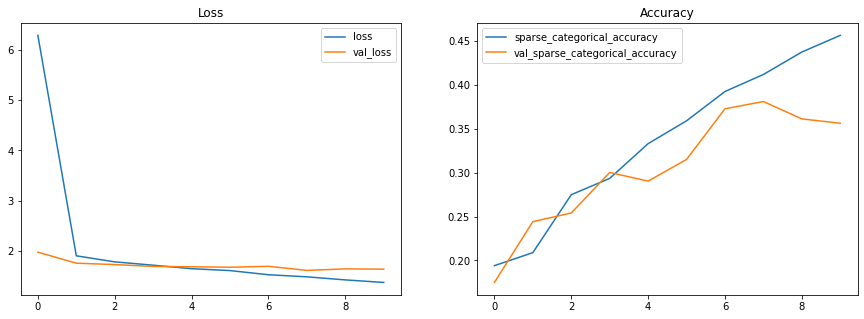

5/5 [==============================] - 0s 78ms/step - loss: 1.6447 - sparse_categorical_accuracy: 0.3564
[1.6446614265441895, 0.3564356565475464]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10

# Free up memory
K.clear_session()

# Build the model
before_prune = build_student_model(image_height, image_width, num_channels, num_classes, model_name='pruning')
print(before_prune.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
before_prune.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Train model
start_time = time.time()
training_results = before_prune.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluate_save_model(before_prune,test_data, training_history,execution_time, 
               learning_rate, batch_size, epochs, optimizer,
               save=False,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "pruning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 112, 112, 16)      882       
_________________________________________________________________
prune_low_magnitude_leaky_re (None, 112, 112, 16)      1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 56, 56, 16)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 28, 28, 32)        9250      
_________________________________________________________________
prune_low_magnitude_leaky_re (None, 28, 28, 32)        1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 32)        1         
_________________________________________________________________
prune_low_magnitude_flatten  (None, 6272)              1   

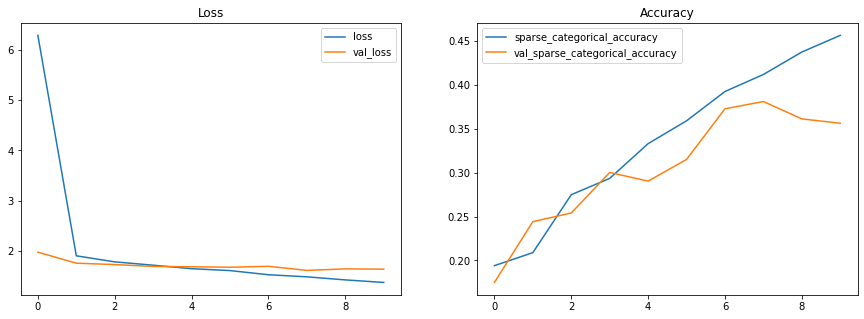

3/3 [==============================] - 0s 71ms/step - loss: 1.8097 - sparse_categorical_accuracy: 0.3739
[1.8096853494644165, 0.37388724088668823]


In [ ]:
epochs = 5
end_step = np.ceil(len(train_xy) / batch_size).astype(np.int32) * epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}
model_for_pruning = prune_low_magnitude(before_prune, **pruning_params)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
model_for_pruning.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.SparseCategoricalAccuracy()])

model_for_pruning.summary()

# Callback
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

# Train
start_time = time.time()
training_results = model_for_pruning.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_save_model(model_for_pruning,test_data, training_history,execution_time, 
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"]
                    )

In [ ]:
after_prune = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

## **<font color="#A41034">Experiment Results</font>**

#### **Compare Models**

In [ ]:
models_metrics_list = glob(experiment_name+"/*_model_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(experiment_name+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,epochs,optimizer,name
0,"2,306,246",11.34 mins,1.45,75.37%,10 MB,0.001,128,20,Adam,teacher_model
2,"206,022",0.32 mins,1.81,37.39%,2 MB,0.010,128,5,Adam,pruning
1,"206,022",1.27 mins,1.61,35.31%,1 MB,0.010,128,10,Adam,student_distill


## **<font color="#A41034">Upload Experiment to Cloud Storage</font>**

### **Login using Google Account**

In [ ]:
# Authenticate
auth.authenticate_user()

### **Save Experiment**

In [ ]:
# Save data details used for the experiment
data_details = {
  "image_width": image_width,
  "image_height": image_height,
  "num_channels": num_channels,
  "num_classes": num_classes,
  "label2index": label2index,
  "index2label": index2label
}

# Upload experiment to cloud storage
upload_experiment(data_details)

user_account anita.mahinpei@gmail.com
Model Bucket: <Bucket: ac215-mushroom-app-models>
experiment_1633376351/teacher_model.json
uploading file experiment_1633376351/teacher_model.json
experiment_1633376351/data_details.json
uploading file experiment_1633376351/data_details.json
experiment_1633376351/teacher_model_train_history.json
uploading file experiment_1633376351/teacher_model_train_history.json
experiment_1633376351/teacher_model.h5
uploading file experiment_1633376351/teacher_model.h5
experiment_1633376351/teacher_model.hdf5
uploading file experiment_1633376351/teacher_model.hdf5
experiment_1633376351/teacher_model_model_metrics.json
uploading file experiment_1633376351/teacher_model_model_metrics.json
Uploading file submit.txt
